In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from preprocessor import get_train_environment
from sklearn.neighbors import KNeighborsRegressor

# Tune n_estimators & max_depth

In [56]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    return [x for i, x in enumerate(data_columns) if i in features]

In [14]:
envGen = get_train_environment(n_splits=5)

In [33]:
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with MSE: {best_score}")

Best parameters: n_estimators=500, max_depth=4 with MSE: 0.3434679680297569


In [26]:
envGen = get_train_environment(n_splits=5)
results = []
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

featureNums = range(1, len(X[0]), 10)

featureNumMSEs = {}

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    model = XGBRegressor(n_estimators=300, max_depth=4)
    model.fit(X_train_fold, y_train_fold)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test_fold)

    mse = mean_squared_error(y_test_fold, predictions)
    print("Overall Fold Mean Squared Error: ", mse)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    
    eps = 0.000001
    lastMSE = None
    for featureNum in featureNums:
        selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
        model = XGBRegressor(n_estimators=300, max_depth=4)
        XT = X_train_fold[:, selectedFeatures]
        model.fit(XT, y_train_fold)
        
        predictions = model.predict(X_test_fold[:, selectedFeatures])
        mse = mean_squared_error(y_test_fold, predictions)
        
        if lastMSE is not None:
            if np.abs(mse - lastMSE) < eps:
                break
            else:
                lastMSE = mse
        else:
            lastMSE = mse
        
        if featureNum in featureNumMSEs:
            featureNumMSEs[featureNum].append(mse)
        else:
            featureNumMSEs[featureNum] = [mse]
        
        print(f"FeatureNum: {featureNum}")
        print("FeatureNum Mean Squared Error: ", mse)

No cached folds found, generating new folds.
Fold: 0
[0.00087534 0.00622908 0.00032064 ... 0.00255878 0.00117591 0.00419969]
Overall Fold Mean Squared Error:  0.353901942265689
FeatureNum: 1
FeatureNum Mean Squared Error:  0.9692063393593039
FeatureNum: 11
FeatureNum Mean Squared Error:  0.5157091084528946
FeatureNum: 21
FeatureNum Mean Squared Error:  0.4941345637537864
FeatureNum: 31
FeatureNum Mean Squared Error:  0.4523677348394458
FeatureNum: 41
FeatureNum Mean Squared Error:  0.43013675469777535
FeatureNum: 51
FeatureNum Mean Squared Error:  0.41550027909278725
FeatureNum: 61
FeatureNum Mean Squared Error:  0.40930974620182226
FeatureNum: 71
FeatureNum Mean Squared Error:  0.40317945620225143
FeatureNum: 81
FeatureNum Mean Squared Error:  0.4147880440301407
FeatureNum: 91
FeatureNum Mean Squared Error:  0.4043570322924917
FeatureNum: 101
FeatureNum Mean Squared Error:  0.4066372219425957
FeatureNum: 111
FeatureNum Mean Squared Error:  0.38235934698887186
FeatureNum: 121
FeatureNu

FeatureNum: 601
FeatureNum Mean Squared Error:  0.34284565747388895
FeatureNum: 611
FeatureNum Mean Squared Error:  0.3403894232901381
Fold: 2
[0.00084813 0.00398291 0.00094197 ... 0.0093509  0.00164198 0.00494004]
Overall Fold Mean Squared Error:  0.31956410326945045
FeatureNum: 1
FeatureNum Mean Squared Error:  0.900780569012271
FeatureNum: 11
FeatureNum Mean Squared Error:  0.48751249817116593
FeatureNum: 21
FeatureNum Mean Squared Error:  0.4143147976170906
FeatureNum: 31
FeatureNum Mean Squared Error:  0.40675104693435193
FeatureNum: 41
FeatureNum Mean Squared Error:  0.39391093815990824
FeatureNum: 51
FeatureNum Mean Squared Error:  0.3893080220808258
FeatureNum: 61
FeatureNum Mean Squared Error:  0.36945186327877777
FeatureNum: 71
FeatureNum Mean Squared Error:  0.38143736710180787
FeatureNum: 81
FeatureNum Mean Squared Error:  0.3701300598759496
FeatureNum: 91
FeatureNum Mean Squared Error:  0.3605180858947327
FeatureNum: 101
FeatureNum Mean Squared Error:  0.3489074400464396
F

FeatureNum: 571
FeatureNum Mean Squared Error:  0.3225644688751106
Fold: 4
[0.00101449 0.00387688 0.00015139 ... 0.00337952 0.00195007 0.00610533]
Overall Fold Mean Squared Error:  0.36163908625259317
FeatureNum: 1
FeatureNum Mean Squared Error:  0.8768628866571453
FeatureNum: 11
FeatureNum Mean Squared Error:  0.5275497423010272
FeatureNum: 21
FeatureNum Mean Squared Error:  0.49854415569046956
FeatureNum: 31
FeatureNum Mean Squared Error:  0.4696443055844613
FeatureNum: 41
FeatureNum Mean Squared Error:  0.46302400138215377
FeatureNum: 51
FeatureNum Mean Squared Error:  0.4321270387146736
FeatureNum: 61
FeatureNum Mean Squared Error:  0.43642062247285596
FeatureNum: 71
FeatureNum Mean Squared Error:  0.4294339267032922
FeatureNum: 81
FeatureNum Mean Squared Error:  0.43225598660322434
FeatureNum: 91
FeatureNum Mean Squared Error:  0.42621531229598225
FeatureNum: 101
FeatureNum Mean Squared Error:  0.3859850965338858
FeatureNum: 111
FeatureNum Mean Squared Error:  0.390314769682693
Fe

In [28]:
avgFeatureNumMSEs = {x: np.mean(featureNumMSEs[x]) for x in featureNumMSEs}

In [33]:
df = pd.Series(avgFeatureNumMSEs)

In [41]:
df = df[1:]

Text(0.5, 1.0, 'XGBoost feature # vs MSE')

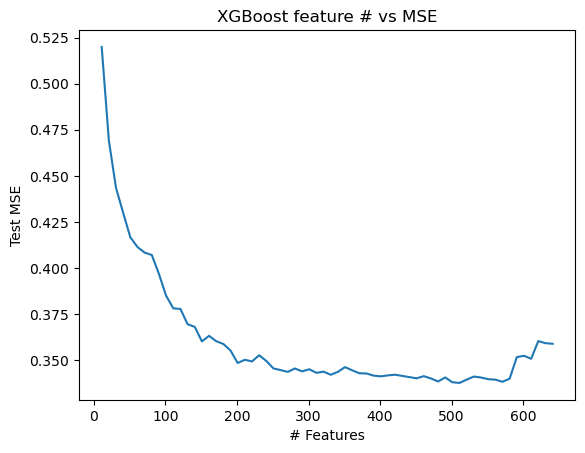

In [45]:
ax = sns.lineplot(df)
ax.set_xlabel("# Features")
ax.set_ylabel("Test MSE")
ax.set_title("XGBoost feature # vs MSE")

In [52]:
envGen = get_train_environment(n_splits=50)

final_mses = []

final_selection_intersection = set()

allSelecteds = []

# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    model = XGBRegressor(n_estimators=300, max_depth=4)
    model.fit(X_train_fold, y_train_fold)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test_fold)

    mse = mean_squared_error(y_test_fold, predictions)
    print("Overall Fold Mean Squared Error: ", mse)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    selectedFeatures = [i for i, x in thresholds[:300]]
    allSelecteds.append(selectedFeatures)
    
    if len(final_selection_intersection) == 0:
        final_selection_intersection = final_selection_intersection.union(selectedFeatures)
    else:
        final_selection_intersection = final_selection_intersection.intersection(selectedFeatures)
    
    XT = X_train_fold[:, selectedFeatures]
    
    model = XGBRegressor(n_estimators=300, max_depth=4)
    
    XT = X_train_fold[:, selectedFeatures]
    model.fit(XT, y_train_fold)

    predictions = model.predict(X_test_fold[:, selectedFeatures])
    mse = mean_squared_error(y_test_fold, predictions)
    print("Post Selection MSE: ", mse)
    final_mses.append(mse)

Found cached folds, using those
Fold: 0
[0.00105676 0.00390564 0.00072056 ... 0.00197862 0.00167946 0.00503123]
Overall Fold Mean Squared Error:  0.30739691952423875
Post Selection MSE:  0.2949283816440758
Fold: 1
[0.00086307 0.0032903  0.00080952 ... 0.00730346 0.00157562 0.00491238]
Overall Fold Mean Squared Error:  0.4315953838014058
Post Selection MSE:  0.47636176633472144
Fold: 2
[0.00106261 0.00212558 0.00017505 ... 0.00248808 0.00118275 0.00431078]
Overall Fold Mean Squared Error:  0.41631241270240654
Post Selection MSE:  0.41440932972657624
Fold: 3
[0.00103823 0.00313793 0.00061732 ... 0.00126935 0.00136498 0.0052184 ]
Overall Fold Mean Squared Error:  0.34891457923268787
Post Selection MSE:  0.33977346453181667
Fold: 4
[0.00103713 0.00315905 0.00089673 ... 0.0051464  0.00125027 0.00501864]
Overall Fold Mean Squared Error:  0.284085729679253
Post Selection MSE:  0.26620519953487004
Fold: 5
[0.00107384 0.00197619 0.00078792 ... 0.00329784 0.00136629 0.00385127]
Overall Fold Mean

[0.00089335 0.00321117 0.00106658 ... 0.00663174 0.00138065 0.00448179]
Overall Fold Mean Squared Error:  0.28445147326962494
Post Selection MSE:  0.3196681762136929
Fold: 48
[0.00087208 0.00275415 0.0002996  ... 0.00729803 0.00154261 0.00597895]
Overall Fold Mean Squared Error:  0.3964570153492568
Post Selection MSE:  0.404442261676574
Fold: 49
[0.00087978 0.00223305 0.00055827 ... 0.00244005 0.00177725 0.00592375]
Overall Fold Mean Squared Error:  0.36088741891824844
Post Selection MSE:  0.37332905802811767


In [55]:
final_selection_intersection

{0,
 1,
 4,
 5,
 9,
 14,
 29,
 30,
 31,
 32,
 34,
 47,
 48,
 60,
 68,
 75,
 80,
 81,
 92,
 93,
 108,
 110,
 111,
 116,
 121,
 123,
 127,
 132,
 138,
 157,
 171,
 172,
 175,
 204,
 217,
 221,
 227,
 228,
 233,
 237,
 253,
 272,
 283,
 288,
 305,
 322,
 323,
 332,
 333,
 379,
 380,
 381,
 398,
 401,
 402,
 426,
 433,
 465,
 494,
 564,
 574,
 610,
 612,
 619,
 641,
 657,
 719,
 803,
 816,
 832,
 890,
 893,
 897,
 900,
 931,
 1000,
 1009,
 1196,
 1217,
 1316,
 1338,
 1339,
 1386,
 1388,
 1439,
 1523,
 1537,
 1553,
 1556,
 1558,
 1560,
 1561,
 1562,
 1563,
 1564,
 1566,
 1567,
 1569,
 1570,
 1571,
 1572,
 1573}

In [57]:
feature_labels(final_selection_intersection)

['release_date',
 'Single-player',
 'Steam Achievements',
 'Full controller support',
 'Steam Cloud',
 'Remote Play on TV',
 'genre_Casual',
 'genre_Indie',
 'genre_Simulation',
 'tag_Action Roguelike',
 'tag_Pixel Graphics',
 'Partial Controller Support',
 'Includes Source SDK',
 'Tracked Controller Support',
 'Profile Features Limited',
 'tag_Memes',
 'tag_Simulation',
 'tag_Open World',
 'genre_Early Access',
 'Steam Leaderboards',
 'pub_HIKARI FIELD',
 'tag_Visual Novel',
 'tag_Casual',
 'tag_Free to Play',
 'In-App Purchases',
 'tag_Tower Defense',
 'pub_KOMODO',
 'tag_Third-Person Shooter',
 'pub_Electronic Arts',
 'tag_Cats',
 'pub_Ubisoft',
 'tag_Turn-Based',
 'tag_PvE',
 'pub_Disney',
 'tag_Arcade',
 'tag_Flight',
 'tag_Clicker',
 'tag_Idler',
 'pub_Sekai Project',
 'tag_Sexual Content',
 'pub_SakuraGame',
 'tag_Minimalist',
 'tag_Side Scroller',
 'tag_Turn-Based Strategy',
 'pub_Spike Chunsoft Co., Ltd.',
 'dev_上海アリス幻樂団',
 "tag_Shoot 'Em Up",
 'dev_Rusty Lake',
 'tag_Hentai',

In [59]:
lasso_coefs

['dev_FC Maker',
 'dev_ILLUSION',
 'pub_HIKARI FIELD',
 'pub_Frontwing USA',
 'dev_上海アリス幻樂団',
 'dev_熊窝dodox',
 'pub_JAST USA',
 'dev_Illwinter Game Design',
 'tag_Voice Control',
 'dev_KOEI TECMO GAMES CO., LTD.',
 'dev_Stratera Games',
 'dev_Puppygames',
 'pub_Shiravune',
 'dev_FURYU Corporation',
 'pub_OTAKU Plan',
 'dev_Grey Havens',
 'tag_Archery',
 'dev_Might and Delight',
 'pub_Kagura Games',
 'dev_NEOWIZ',
 'dev_EGAMER',
 'pub_Artifex Mundi',
 'pub_Electronic Arts',
 'pub_Outright Games Ltd.',
 'pub_Slitherine Ltd.',
 'pub_Spike Chunsoft Co., Ltd.',
 'pub_Clouded Leopard Entertainment',
 'dev_Daedalic Entertainment',
 'pub_Aerosoft GmbH',
 'pub_Activision',
 'pub_Alice Publication',
 'pub_Sekai Project',
 'pub_Bandai Namco Entertainment',
 'dev_Ubisoft Shanghai',
 'tag_Pool',
 'pub_PlayStation PC LLC',
 'dev_Rockstar Games',
 'pub_0Cube',
 'pub_KOMODO',
 'dev_Cheesecake Dev',
 'pub_BANDAI NAMCO Entertainment',
 'dev_PixelFade',
 'pub_SimonCreative',
 'ln.curatorsp1',
 'dev_Stard

In [60]:
xgb_final_features = feature_labels(final_selection_intersection)

In [70]:
xgb_final_features

['release_date',
 'Single-player',
 'Steam Achievements',
 'Full controller support',
 'Steam Cloud',
 'Remote Play on TV',
 'genre_Casual',
 'genre_Indie',
 'genre_Simulation',
 'tag_Action Roguelike',
 'tag_Pixel Graphics',
 'Partial Controller Support',
 'Includes Source SDK',
 'Tracked Controller Support',
 'Profile Features Limited',
 'tag_Memes',
 'tag_Simulation',
 'tag_Open World',
 'genre_Early Access',
 'Steam Leaderboards',
 'pub_HIKARI FIELD',
 'tag_Visual Novel',
 'tag_Casual',
 'tag_Free to Play',
 'In-App Purchases',
 'tag_Tower Defense',
 'pub_KOMODO',
 'tag_Third-Person Shooter',
 'pub_Electronic Arts',
 'tag_Cats',
 'pub_Ubisoft',
 'tag_Turn-Based',
 'tag_PvE',
 'pub_Disney',
 'tag_Arcade',
 'tag_Flight',
 'tag_Clicker',
 'tag_Idler',
 'pub_Sekai Project',
 'tag_Sexual Content',
 'pub_SakuraGame',
 'tag_Minimalist',
 'tag_Side Scroller',
 'tag_Turn-Based Strategy',
 'pub_Spike Chunsoft Co., Ltd.',
 'dev_上海アリス幻樂団',
 "tag_Shoot 'Em Up",
 'dev_Rusty Lake',
 'tag_Hentai',

Text(0.5, 1.0, 'Final XGBoost Model CV Results')

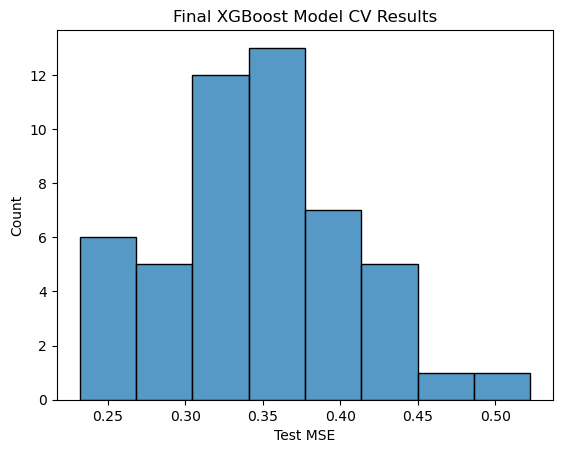

In [51]:
ax = sns.histplot(final_mses)
ax.set_xlabel("Test MSE")
ax.set_title("Final XGBoost Model CV Results")

In [73]:
envGen = get_train_environment(n_splits=5)
results = []
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

featureNums = range(1, len(X[0]), 50)

KFeatureNumMSEs = {}

n_neighbors = range(2, 50, 4)

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    xgb = XGBRegressor(n_estimators=300, max_depth=4)
    xgb.fit(X_train_fold, y_train_fold)

    xgb_thresholds = enumerate(xgb.feature_importances_)
    xgb_thresholds = [x for x in thresholds]
    xgb_thresholds.sort(key=lambda x: x[1], reverse=True)
    
    
    eps = 0.000001
    for k in n_neighbors:
        lastMSE = None
        for featureNum in featureNums:
            selectedFeatures = [i for i, x in xgb_thresholds[:featureNum]]

            model = KNeighborsRegressor(n_neighbors=k)
            XT = X_train_fold[:, selectedFeatures]
            model.fit(XT, y_train_fold)

            predictions = model.predict(X_test_fold[:, selectedFeatures])
            mse = mean_squared_error(y_test_fold, predictions)

            if lastMSE is not None:
                if np.abs(mse - lastMSE) < eps:
                    break
                else:
                    lastMSE = mse
            else:
                lastMSE = mse

            if (k, featureNum) in featureNumMSEs:
                featureNumMSEs[(k, featureNum)].append(mse)
            else:
                featureNumMSEs[(k, featureNum)] = [mse]

            print(f"K, FeatureNum: {k}, {featureNum}")
            print("FeatureNum Mean Squared Error: ", mse)

Found cached folds, using those
Fold: 0
K, FeatureNum: 2, 1
FeatureNum Mean Squared Error:  1.9237069816634143
K, FeatureNum: 2, 51
FeatureNum Mean Squared Error:  0.6749776719713425
K, FeatureNum: 2, 101
FeatureNum Mean Squared Error:  0.6613205864127661
K, FeatureNum: 2, 151
FeatureNum Mean Squared Error:  0.6833978966957691
K, FeatureNum: 2, 201
FeatureNum Mean Squared Error:  0.6673376527583401
K, FeatureNum: 2, 251
FeatureNum Mean Squared Error:  0.713848918227216
K, FeatureNum: 2, 301
FeatureNum Mean Squared Error:  0.7139800774193317
K, FeatureNum: 2, 351
FeatureNum Mean Squared Error:  0.6988295569547261
K, FeatureNum: 2, 401
FeatureNum Mean Squared Error:  0.6903533911241007
K, FeatureNum: 2, 451
FeatureNum Mean Squared Error:  0.6741133770414343
K, FeatureNum: 2, 501
FeatureNum Mean Squared Error:  0.6802858328698278
K, FeatureNum: 2, 551
FeatureNum Mean Squared Error:  0.678165636620825
K, FeatureNum: 2, 601
FeatureNum Mean Squared Error:  0.6767912332373591
K, FeatureNum: 2

K, FeatureNum: 14, 801
FeatureNum Mean Squared Error:  0.5567652413954735
K, FeatureNum: 14, 851
FeatureNum Mean Squared Error:  0.555743807029084
K, FeatureNum: 14, 901
FeatureNum Mean Squared Error:  0.556221317412205
K, FeatureNum: 14, 951
FeatureNum Mean Squared Error:  0.555326880195301
K, FeatureNum: 14, 1001
FeatureNum Mean Squared Error:  0.554283735081035
K, FeatureNum: 14, 1051
FeatureNum Mean Squared Error:  0.5544083502822187
K, FeatureNum: 14, 1101
FeatureNum Mean Squared Error:  0.5562412592197721
K, FeatureNum: 14, 1151
FeatureNum Mean Squared Error:  0.5565232679021461
K, FeatureNum: 14, 1201
FeatureNum Mean Squared Error:  0.5560641923774412
K, FeatureNum: 14, 1251
FeatureNum Mean Squared Error:  0.5533055959641382
K, FeatureNum: 14, 1301
FeatureNum Mean Squared Error:  0.5523175836326165
K, FeatureNum: 14, 1351
FeatureNum Mean Squared Error:  0.5524646189417843
K, FeatureNum: 14, 1401
FeatureNum Mean Squared Error:  0.550800684680034
K, FeatureNum: 14, 1451
FeatureNum

K, FeatureNum: 26, 1551
FeatureNum Mean Squared Error:  0.575010513221205
K, FeatureNum: 30, 1
FeatureNum Mean Squared Error:  0.9663585160193991
K, FeatureNum: 30, 51
FeatureNum Mean Squared Error:  0.668099538168768
K, FeatureNum: 30, 101
FeatureNum Mean Squared Error:  0.6717777566274054
K, FeatureNum: 30, 151
FeatureNum Mean Squared Error:  0.648217593841494
K, FeatureNum: 30, 201
FeatureNum Mean Squared Error:  0.6518192378150153
K, FeatureNum: 30, 251
FeatureNum Mean Squared Error:  0.6343130601592457
K, FeatureNum: 30, 301
FeatureNum Mean Squared Error:  0.6221768755622386
K, FeatureNum: 30, 351
FeatureNum Mean Squared Error:  0.6191125589569956
K, FeatureNum: 30, 401
FeatureNum Mean Squared Error:  0.6155482904518256
K, FeatureNum: 30, 451
FeatureNum Mean Squared Error:  0.6078857066706613
K, FeatureNum: 30, 501
FeatureNum Mean Squared Error:  0.6042748019158113
K, FeatureNum: 30, 551
FeatureNum Mean Squared Error:  0.5999906772927222
K, FeatureNum: 30, 601
FeatureNum Mean Squa

K, FeatureNum: 42, 751
FeatureNum Mean Squared Error:  0.6146339920503338
K, FeatureNum: 42, 801
FeatureNum Mean Squared Error:  0.6146375249407151
K, FeatureNum: 42, 851
FeatureNum Mean Squared Error:  0.6147464927078857
K, FeatureNum: 42, 901
FeatureNum Mean Squared Error:  0.616135527874499
K, FeatureNum: 42, 951
FeatureNum Mean Squared Error:  0.6097909742378659
K, FeatureNum: 42, 1001
FeatureNum Mean Squared Error:  0.6103255011469457
K, FeatureNum: 42, 1051
FeatureNum Mean Squared Error:  0.6101843179708467
K, FeatureNum: 42, 1101
FeatureNum Mean Squared Error:  0.6099380506252433
K, FeatureNum: 42, 1151
FeatureNum Mean Squared Error:  0.6097860599788071
K, FeatureNum: 42, 1201
FeatureNum Mean Squared Error:  0.6101528686488711
K, FeatureNum: 42, 1251
FeatureNum Mean Squared Error:  0.6113367000102785
K, FeatureNum: 42, 1301
FeatureNum Mean Squared Error:  0.6103883097965747
K, FeatureNum: 42, 1351
FeatureNum Mean Squared Error:  0.6099141741403644
K, FeatureNum: 42, 1401
Feature

K, FeatureNum: 6, 1551
FeatureNum Mean Squared Error:  0.5874392980646246
K, FeatureNum: 10, 1
FeatureNum Mean Squared Error:  1.2366898682275715
K, FeatureNum: 10, 51
FeatureNum Mean Squared Error:  0.6337499683200793
K, FeatureNum: 10, 101
FeatureNum Mean Squared Error:  0.6695392874473723
K, FeatureNum: 10, 151
FeatureNum Mean Squared Error:  0.6600363365191755
K, FeatureNum: 10, 201
FeatureNum Mean Squared Error:  0.6721162928256884
K, FeatureNum: 10, 251
FeatureNum Mean Squared Error:  0.6372709843639351
K, FeatureNum: 10, 301
FeatureNum Mean Squared Error:  0.6233759548362487
K, FeatureNum: 10, 351
FeatureNum Mean Squared Error:  0.6213414644062074
K, FeatureNum: 10, 401
FeatureNum Mean Squared Error:  0.618985937456175
K, FeatureNum: 10, 451
FeatureNum Mean Squared Error:  0.6136685576418606
K, FeatureNum: 10, 501
FeatureNum Mean Squared Error:  0.606233637868606
K, FeatureNum: 10, 551
FeatureNum Mean Squared Error:  0.5975901798345289
K, FeatureNum: 10, 601
FeatureNum Mean Squa

K, FeatureNum: 22, 751
FeatureNum Mean Squared Error:  0.6080469079963131
K, FeatureNum: 22, 801
FeatureNum Mean Squared Error:  0.61018935266989
K, FeatureNum: 22, 851
FeatureNum Mean Squared Error:  0.6078158349035296
K, FeatureNum: 22, 901
FeatureNum Mean Squared Error:  0.6074813069632298
K, FeatureNum: 22, 951
FeatureNum Mean Squared Error:  0.6072859300820368
K, FeatureNum: 22, 1001
FeatureNum Mean Squared Error:  0.605598419397482
K, FeatureNum: 22, 1051
FeatureNum Mean Squared Error:  0.6056996866094745
K, FeatureNum: 22, 1101
FeatureNum Mean Squared Error:  0.6052923466802934
K, FeatureNum: 22, 1151
FeatureNum Mean Squared Error:  0.607182840268414
K, FeatureNum: 22, 1201
FeatureNum Mean Squared Error:  0.6057407126054741
K, FeatureNum: 22, 1251
FeatureNum Mean Squared Error:  0.6036003970539584
K, FeatureNum: 22, 1301
FeatureNum Mean Squared Error:  0.6040008541890398
K, FeatureNum: 22, 1351
FeatureNum Mean Squared Error:  0.6018074354599375
K, FeatureNum: 22, 1401
FeatureNum

K, FeatureNum: 34, 1501
FeatureNum Mean Squared Error:  0.6170318638645063
K, FeatureNum: 34, 1551
FeatureNum Mean Squared Error:  0.6193759284125983
K, FeatureNum: 38, 1
FeatureNum Mean Squared Error:  0.9055693311645111
K, FeatureNum: 38, 51
FeatureNum Mean Squared Error:  0.6932895479913749
K, FeatureNum: 38, 101
FeatureNum Mean Squared Error:  0.7280452881047963
K, FeatureNum: 38, 151
FeatureNum Mean Squared Error:  0.6968695191552636
K, FeatureNum: 38, 201
FeatureNum Mean Squared Error:  0.7031738359340156
K, FeatureNum: 38, 251
FeatureNum Mean Squared Error:  0.6852670001661407
K, FeatureNum: 38, 301
FeatureNum Mean Squared Error:  0.6796264385794021
K, FeatureNum: 38, 351
FeatureNum Mean Squared Error:  0.6646333983267171
K, FeatureNum: 38, 401
FeatureNum Mean Squared Error:  0.6674036289572141
K, FeatureNum: 38, 451
FeatureNum Mean Squared Error:  0.656653122329413
K, FeatureNum: 38, 501
FeatureNum Mean Squared Error:  0.6553085038413584
K, FeatureNum: 38, 551
FeatureNum Mean S

K, FeatureNum: 2, 701
FeatureNum Mean Squared Error:  0.6584328146765198
K, FeatureNum: 2, 751
FeatureNum Mean Squared Error:  0.6591661219671149
K, FeatureNum: 2, 801
FeatureNum Mean Squared Error:  0.6466881085151602
K, FeatureNum: 2, 851
FeatureNum Mean Squared Error:  0.6450528158302675
K, FeatureNum: 2, 901
FeatureNum Mean Squared Error:  0.6320616716882154
K, FeatureNum: 2, 951
FeatureNum Mean Squared Error:  0.6347624132172042
K, FeatureNum: 2, 1001
FeatureNum Mean Squared Error:  0.635833156824527
K, FeatureNum: 2, 1051
FeatureNum Mean Squared Error:  0.6377228493844465
K, FeatureNum: 2, 1101
FeatureNum Mean Squared Error:  0.6386570716733103
K, FeatureNum: 2, 1151
FeatureNum Mean Squared Error:  0.6450612869794448
K, FeatureNum: 2, 1201
FeatureNum Mean Squared Error:  0.651715570764687
K, FeatureNum: 2, 1251
FeatureNum Mean Squared Error:  0.6509746273229662
K, FeatureNum: 2, 1301
FeatureNum Mean Squared Error:  0.649036801035389
K, FeatureNum: 2, 1351
FeatureNum Mean Squared 

K, FeatureNum: 14, 1501
FeatureNum Mean Squared Error:  0.5402112183450641
K, FeatureNum: 14, 1551
FeatureNum Mean Squared Error:  0.5416555563335851
K, FeatureNum: 18, 1
FeatureNum Mean Squared Error:  1.0212894719381023
K, FeatureNum: 18, 51
FeatureNum Mean Squared Error:  0.5997155366896452
K, FeatureNum: 18, 101
FeatureNum Mean Squared Error:  0.6170169475013345
K, FeatureNum: 18, 151
FeatureNum Mean Squared Error:  0.6111118505117386
K, FeatureNum: 18, 201
FeatureNum Mean Squared Error:  0.620532310391365
K, FeatureNum: 18, 251
FeatureNum Mean Squared Error:  0.6011339534006213
K, FeatureNum: 18, 301
FeatureNum Mean Squared Error:  0.5897659401841737
K, FeatureNum: 18, 351
FeatureNum Mean Squared Error:  0.5813297290638368
K, FeatureNum: 18, 401
FeatureNum Mean Squared Error:  0.5812840429156535
K, FeatureNum: 18, 451
FeatureNum Mean Squared Error:  0.580381087980633
K, FeatureNum: 18, 501
FeatureNum Mean Squared Error:  0.5705206396662559
K, FeatureNum: 18, 551
FeatureNum Mean Sq

K, FeatureNum: 30, 651
FeatureNum Mean Squared Error:  0.5932443387504106
K, FeatureNum: 30, 701
FeatureNum Mean Squared Error:  0.5914103004289316
K, FeatureNum: 30, 751
FeatureNum Mean Squared Error:  0.588330955174925
K, FeatureNum: 30, 801
FeatureNum Mean Squared Error:  0.585136897081025
K, FeatureNum: 30, 851
FeatureNum Mean Squared Error:  0.5819723992459728
K, FeatureNum: 30, 901
FeatureNum Mean Squared Error:  0.583843414888454
K, FeatureNum: 30, 951
FeatureNum Mean Squared Error:  0.5815569979551807
K, FeatureNum: 30, 1001
FeatureNum Mean Squared Error:  0.5823766903504348
K, FeatureNum: 30, 1051
FeatureNum Mean Squared Error:  0.5798327002186666
K, FeatureNum: 30, 1101
FeatureNum Mean Squared Error:  0.5787494307280274
K, FeatureNum: 30, 1151
FeatureNum Mean Squared Error:  0.5787455386439103
K, FeatureNum: 30, 1201
FeatureNum Mean Squared Error:  0.5779947167725324
K, FeatureNum: 30, 1251
FeatureNum Mean Squared Error:  0.578044116471086
K, FeatureNum: 30, 1301
FeatureNum M

K, FeatureNum: 42, 1401
FeatureNum Mean Squared Error:  0.5982259350139906
K, FeatureNum: 42, 1451
FeatureNum Mean Squared Error:  0.5986363111760004
K, FeatureNum: 42, 1501
FeatureNum Mean Squared Error:  0.5977629626772509
K, FeatureNum: 42, 1551
FeatureNum Mean Squared Error:  0.5968123744195036
K, FeatureNum: 46, 1
FeatureNum Mean Squared Error:  0.9098670504702601
K, FeatureNum: 46, 51
FeatureNum Mean Squared Error:  0.6508688311742608
K, FeatureNum: 46, 101
FeatureNum Mean Squared Error:  0.6802102682757485
K, FeatureNum: 46, 151
FeatureNum Mean Squared Error:  0.6610675752944962
K, FeatureNum: 46, 201
FeatureNum Mean Squared Error:  0.6713494713106399
K, FeatureNum: 46, 251
FeatureNum Mean Squared Error:  0.6556430610681155
K, FeatureNum: 46, 301
FeatureNum Mean Squared Error:  0.6460842674715424
K, FeatureNum: 46, 351
FeatureNum Mean Squared Error:  0.6438438092192277
K, FeatureNum: 46, 401
FeatureNum Mean Squared Error:  0.6381137280518147
K, FeatureNum: 46, 451
FeatureNum Mea

K, FeatureNum: 10, 601
FeatureNum Mean Squared Error:  0.5187018073838257
K, FeatureNum: 10, 651
FeatureNum Mean Squared Error:  0.5168823499499279
K, FeatureNum: 10, 701
FeatureNum Mean Squared Error:  0.5232464672300283
K, FeatureNum: 10, 751
FeatureNum Mean Squared Error:  0.526792928397215
K, FeatureNum: 10, 801
FeatureNum Mean Squared Error:  0.5309196586578553
K, FeatureNum: 10, 851
FeatureNum Mean Squared Error:  0.5327788753350611
K, FeatureNum: 10, 901
FeatureNum Mean Squared Error:  0.5299333648745165
K, FeatureNum: 10, 951
FeatureNum Mean Squared Error:  0.5270192911069919
K, FeatureNum: 10, 1001
FeatureNum Mean Squared Error:  0.5281824310284746
K, FeatureNum: 10, 1051
FeatureNum Mean Squared Error:  0.5273984872833964
K, FeatureNum: 10, 1101
FeatureNum Mean Squared Error:  0.5262260646402347
K, FeatureNum: 10, 1151
FeatureNum Mean Squared Error:  0.526128096880069
K, FeatureNum: 10, 1201
FeatureNum Mean Squared Error:  0.5242789055010045
K, FeatureNum: 10, 1251
FeatureNum 

K, FeatureNum: 22, 1351
FeatureNum Mean Squared Error:  0.541852035106911
K, FeatureNum: 22, 1401
FeatureNum Mean Squared Error:  0.5418036144888543
K, FeatureNum: 22, 1451
FeatureNum Mean Squared Error:  0.5430075695610629
K, FeatureNum: 22, 1501
FeatureNum Mean Squared Error:  0.5443270274832469
K, FeatureNum: 22, 1551
FeatureNum Mean Squared Error:  0.5440863595424554
K, FeatureNum: 26, 1
FeatureNum Mean Squared Error:  0.8893728815971551
K, FeatureNum: 26, 51
FeatureNum Mean Squared Error:  0.5546537838090125
K, FeatureNum: 26, 101
FeatureNum Mean Squared Error:  0.5881432697886338
K, FeatureNum: 26, 151
FeatureNum Mean Squared Error:  0.5771096262039025
K, FeatureNum: 26, 201
FeatureNum Mean Squared Error:  0.579181516552084
K, FeatureNum: 26, 251
FeatureNum Mean Squared Error:  0.5572819011526192
K, FeatureNum: 26, 301
FeatureNum Mean Squared Error:  0.5534156113157326
K, FeatureNum: 26, 351
FeatureNum Mean Squared Error:  0.5517108864747013
K, FeatureNum: 26, 401
FeatureNum Mean

K, FeatureNum: 38, 551
FeatureNum Mean Squared Error:  0.5662058536058614
K, FeatureNum: 38, 601
FeatureNum Mean Squared Error:  0.5671903836553481
K, FeatureNum: 38, 651
FeatureNum Mean Squared Error:  0.5655283406253528
K, FeatureNum: 38, 701
FeatureNum Mean Squared Error:  0.5667839337532897
K, FeatureNum: 38, 751
FeatureNum Mean Squared Error:  0.5687487524517273
K, FeatureNum: 38, 801
FeatureNum Mean Squared Error:  0.567226525197761
K, FeatureNum: 38, 851
FeatureNum Mean Squared Error:  0.5683332880599815
K, FeatureNum: 38, 901
FeatureNum Mean Squared Error:  0.5706882351084364
K, FeatureNum: 38, 951
FeatureNum Mean Squared Error:  0.5718439694817894
K, FeatureNum: 38, 1001
FeatureNum Mean Squared Error:  0.5722801869236308
K, FeatureNum: 38, 1051
FeatureNum Mean Squared Error:  0.5728390449537825
K, FeatureNum: 38, 1101
FeatureNum Mean Squared Error:  0.5722270864988124
K, FeatureNum: 38, 1151
FeatureNum Mean Squared Error:  0.5754770359516268
K, FeatureNum: 38, 1201
FeatureNum 

K, FeatureNum: 2, 1301
FeatureNum Mean Squared Error:  0.6852230691234279
K, FeatureNum: 2, 1351
FeatureNum Mean Squared Error:  0.6803704931711342
K, FeatureNum: 2, 1401
FeatureNum Mean Squared Error:  0.6800693574319752
K, FeatureNum: 2, 1451
FeatureNum Mean Squared Error:  0.6788021222512329
K, FeatureNum: 2, 1501
FeatureNum Mean Squared Error:  0.6778859605502409
K, FeatureNum: 2, 1551
FeatureNum Mean Squared Error:  0.6751949088273927
K, FeatureNum: 6, 1
FeatureNum Mean Squared Error:  1.1858820734722415
K, FeatureNum: 6, 51
FeatureNum Mean Squared Error:  0.6266304991290301
K, FeatureNum: 6, 101
FeatureNum Mean Squared Error:  0.6143168106039136
K, FeatureNum: 6, 151
FeatureNum Mean Squared Error:  0.6008682489329048
K, FeatureNum: 6, 201
FeatureNum Mean Squared Error:  0.5994663585836673
K, FeatureNum: 6, 251
FeatureNum Mean Squared Error:  0.6080039022051458
K, FeatureNum: 6, 301
FeatureNum Mean Squared Error:  0.5894701188114851
K, FeatureNum: 6, 351
FeatureNum Mean Squared Er

K, FeatureNum: 18, 501
FeatureNum Mean Squared Error:  0.5941790675906194
K, FeatureNum: 18, 551
FeatureNum Mean Squared Error:  0.5870676352322901
K, FeatureNum: 18, 601
FeatureNum Mean Squared Error:  0.5794924262517716
K, FeatureNum: 18, 651
FeatureNum Mean Squared Error:  0.5761187017915872
K, FeatureNum: 18, 701
FeatureNum Mean Squared Error:  0.5687543270432954
K, FeatureNum: 18, 751
FeatureNum Mean Squared Error:  0.5676393302224411
K, FeatureNum: 18, 801
FeatureNum Mean Squared Error:  0.5652371761403123
K, FeatureNum: 18, 851
FeatureNum Mean Squared Error:  0.5628864586320389
K, FeatureNum: 18, 901
FeatureNum Mean Squared Error:  0.5624304346863724
K, FeatureNum: 18, 951
FeatureNum Mean Squared Error:  0.5611515067641947
K, FeatureNum: 18, 1001
FeatureNum Mean Squared Error:  0.5644102000198769
K, FeatureNum: 18, 1051
FeatureNum Mean Squared Error:  0.564172676962233
K, FeatureNum: 18, 1101
FeatureNum Mean Squared Error:  0.5627141188892052
K, FeatureNum: 18, 1151
FeatureNum M

K, FeatureNum: 30, 1251
FeatureNum Mean Squared Error:  0.5998583178570577
K, FeatureNum: 30, 1301
FeatureNum Mean Squared Error:  0.6000600319342518
K, FeatureNum: 30, 1351
FeatureNum Mean Squared Error:  0.5998512203647842
K, FeatureNum: 30, 1401
FeatureNum Mean Squared Error:  0.599191630785022
K, FeatureNum: 30, 1451
FeatureNum Mean Squared Error:  0.5981460508595937
K, FeatureNum: 30, 1501
FeatureNum Mean Squared Error:  0.598920935315891
K, FeatureNum: 30, 1551
FeatureNum Mean Squared Error:  0.5990376649984744
K, FeatureNum: 34, 1
FeatureNum Mean Squared Error:  0.9000549379158435
K, FeatureNum: 34, 51
FeatureNum Mean Squared Error:  0.6913733462144784
K, FeatureNum: 34, 101
FeatureNum Mean Squared Error:  0.7077675267188067
K, FeatureNum: 34, 151
FeatureNum Mean Squared Error:  0.6774513752023101
K, FeatureNum: 34, 201
FeatureNum Mean Squared Error:  0.6749452111731308
K, FeatureNum: 34, 251
FeatureNum Mean Squared Error:  0.6666652240338738
K, FeatureNum: 34, 301
FeatureNum Me

K, FeatureNum: 46, 451
FeatureNum Mean Squared Error:  0.6639443213520824
K, FeatureNum: 46, 501
FeatureNum Mean Squared Error:  0.6571129871989856
K, FeatureNum: 46, 551
FeatureNum Mean Squared Error:  0.6500027176731861
K, FeatureNum: 46, 601
FeatureNum Mean Squared Error:  0.6484012223121389
K, FeatureNum: 46, 651
FeatureNum Mean Squared Error:  0.6436843115524283
K, FeatureNum: 46, 701
FeatureNum Mean Squared Error:  0.6379553361538397
K, FeatureNum: 46, 751
FeatureNum Mean Squared Error:  0.6357306556351984
K, FeatureNum: 46, 801
FeatureNum Mean Squared Error:  0.6355644901854091
K, FeatureNum: 46, 851
FeatureNum Mean Squared Error:  0.6356821123916658
K, FeatureNum: 46, 901
FeatureNum Mean Squared Error:  0.6352683279392033
K, FeatureNum: 46, 951
FeatureNum Mean Squared Error:  0.6346819106037302
K, FeatureNum: 46, 1001
FeatureNum Mean Squared Error:  0.6353315001616181
K, FeatureNum: 46, 1051
FeatureNum Mean Squared Error:  0.6342969697248256
K, FeatureNum: 46, 1101
FeatureNum M

In [90]:
KFeatureNumMSEs = {x: featureNumMSEs[x] for x in featureNumMSEs if type(x) is tuple and (x[1] - 1) % 50 == 0 and (len(featureNumMSEs[x]) >= 5)}

In [87]:
KFeatureNumMSEs

{(2, 1): [1.9237069816634143,
  1.9237069816634143,
  0.9256595449713565,
  0.9381915526354774,
  0.9313170731443021,
  1.290814810685514],
 (2, 51): [0.6749776719713425,
  0.6749776719713425,
  0.7084885567706881,
  0.6252342378006601,
  0.6252662096508032,
  0.6954230317914696],
 (2, 101): [0.6613205864127661,
  0.6613205864127661,
  0.7838954168415992,
  0.6732938729730804,
  0.6609570209746941,
  0.6866799477074051],
 (2, 151): [0.6833978966957691,
  0.6833978966957691,
  0.7764197807796369,
  0.7012598594566027,
  0.6651146131417733,
  0.7069168190522468],
 (2, 201): [0.6673376527583401,
  0.6673376527583401,
  0.7631834337910689,
  0.6819382665013637,
  0.6447594231180721,
  0.7110454810934832],
 (2, 251): [0.713848918227216,
  0.713848918227216,
  0.7494049384392998,
  0.7152472495006865,
  0.6406018278033336,
  0.7018007272215849],
 (2, 301): [0.7139800774193317,
  0.7139800774193317,
  0.7438593895940385,
  0.6890620915343786,
  0.6197009926047009,
  0.6806944207032644],
 (2, 

In [91]:
for x in KFeatureNumMSEs:
    if len(KFeatureNumMSEs[x]) > 5:
        KFeatureNumMSEs[x] = KFeatureNumMSEs[x][-5:]

In [92]:
KFeatureNumMSEs

{(2, 1): [1.9237069816634143,
  0.9256595449713565,
  0.9381915526354774,
  0.9313170731443021,
  1.290814810685514],
 (2, 51): [0.6749776719713425,
  0.7084885567706881,
  0.6252342378006601,
  0.6252662096508032,
  0.6954230317914696],
 (2, 101): [0.6613205864127661,
  0.7838954168415992,
  0.6732938729730804,
  0.6609570209746941,
  0.6866799477074051],
 (2, 151): [0.6833978966957691,
  0.7764197807796369,
  0.7012598594566027,
  0.6651146131417733,
  0.7069168190522468],
 (2, 201): [0.6673376527583401,
  0.7631834337910689,
  0.6819382665013637,
  0.6447594231180721,
  0.7110454810934832],
 (2, 251): [0.713848918227216,
  0.7494049384392998,
  0.7152472495006865,
  0.6406018278033336,
  0.7018007272215849],
 (2, 301): [0.7139800774193317,
  0.7438593895940385,
  0.6890620915343786,
  0.6197009926047009,
  0.6806944207032644],
 (2, 351): [0.6988295569547261,
  0.7622426086962121,
  0.6680885870155742,
  0.6091537754484249,
  0.67807242755123],
 (2, 401): [0.6903533911241007,
  0.750

In [103]:
make_df = []
for x in KFeatureNumMSEs:
    mses = KFeatureNumMSEs[x]
    make_df.append({"k": x[0], "featureNum": x[1], "mse": np.mean(mses)})

In [106]:
kfmse = pd.DataFrame.from_dict(make_df)

In [107]:
kfmse

,k,featureNum,mse
0,2,1,1.201938
1,2,51,0.665878
2,2,101,0.693229
3,2,151,0.706622
4,2,201,0.693653
...,...,...,...
379,46,1351,0.616363
380,46,1401,0.616084
381,46,1451,0.615647
382,46,1501,0.616583


<Axes: xlabel='k', ylabel='mse'>

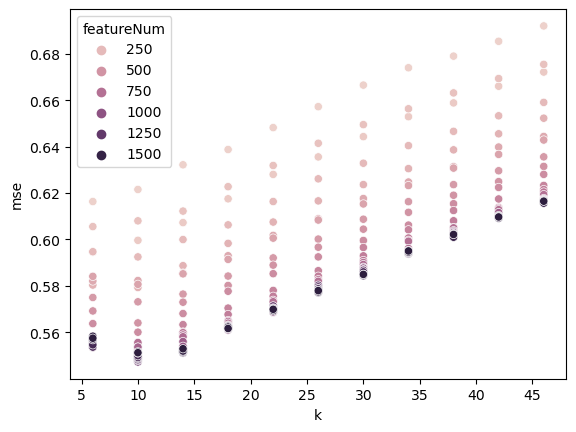

In [116]:
sns.scatterplot(data=kfmse[(kfmse["featureNum"] > 100) & (kfmse["k"] > 2)], x="k", hue="featureNum", y="mse")

In [113]:
kfmse.sort_values("mse")

,k,featureNum,mse
87,10,1151,0.547251
88,10,1201,0.547885
89,10,1251,0.548204
86,10,1101,0.548451
90,10,1301,0.548783
...,...,...,...
128,18,1,1.015734
96,14,1,1.126154
0,2,1,1.201938
64,10,1,1.211852


In [120]:
pd.Series(final_mses).to_csv("XGB_final_model_CV_results.csv")

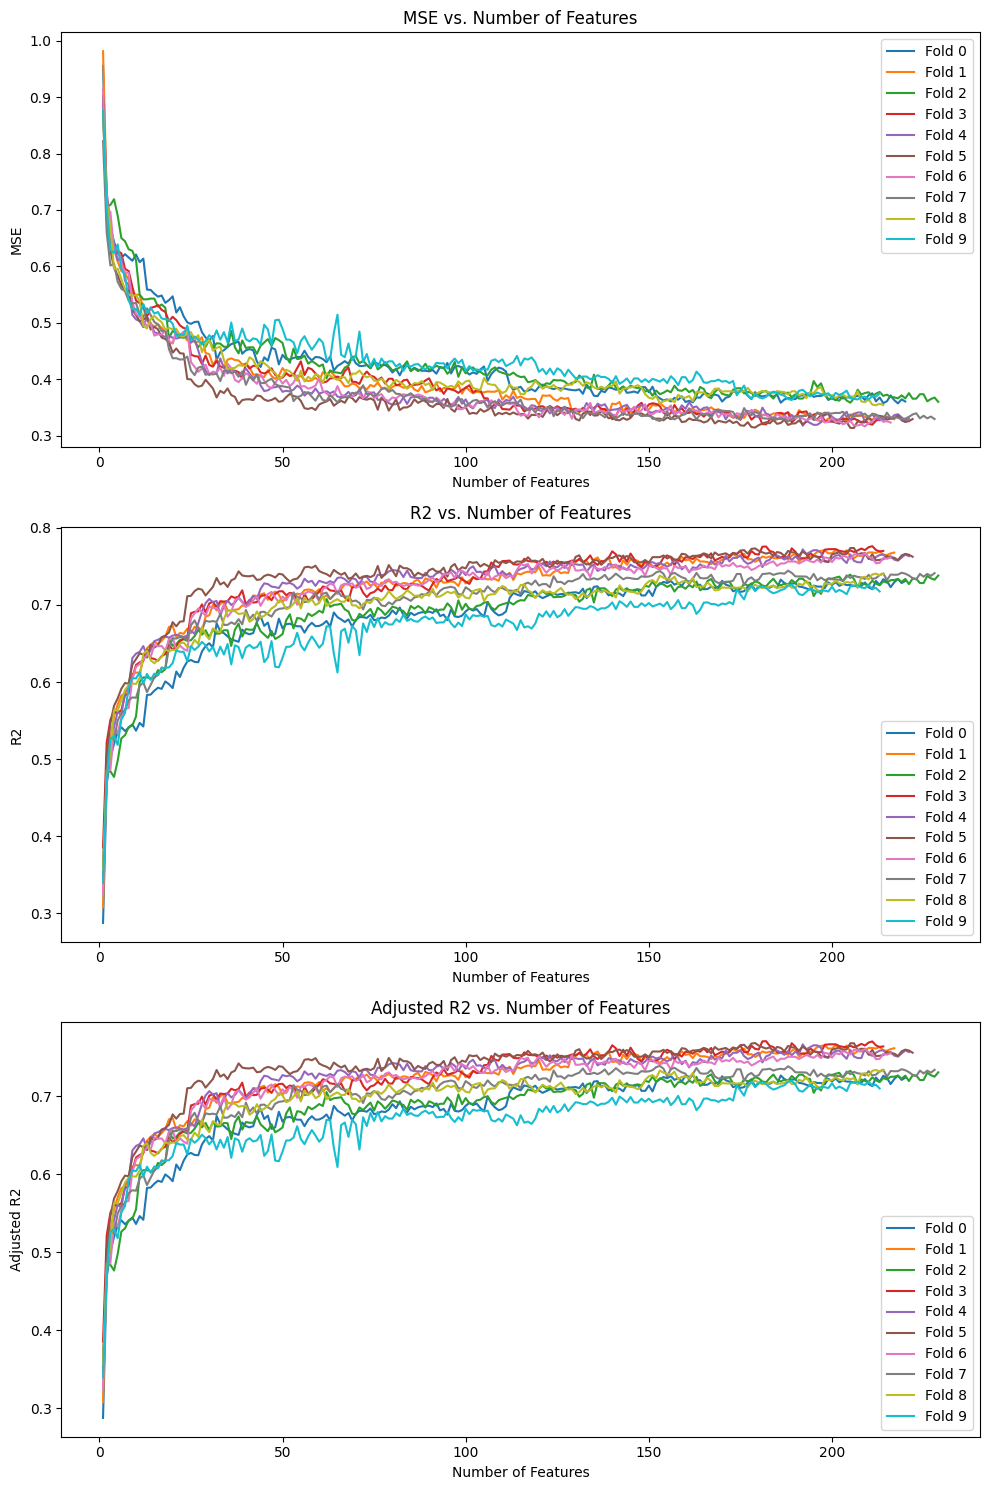

In [16]:
# Preparing data for plotting
data_by_fold = {}
for entry in results:
    fold = entry['Fold']
    if fold not in data_by_fold:
        data_by_fold[fold] = {'Number of Features': [], 'MSE': [], 'R2': [], 'Adjusted R2': []}
    data_by_fold[fold]['Number of Features'].append(entry['Number of Features'])
    data_by_fold[fold]['MSE'].append(entry['MSE'])
    data_by_fold[fold]['R2'].append(entry['R2'])
    data_by_fold[fold]['Adjusted R2'].append(entry['Adjusted R2'])

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plotting MSE
for fold, data in data_by_fold.items():
    axes[0].plot(data['Number of Features'], data['MSE'], label=f'Fold {fold}')
axes[0].set_title('MSE vs. Number of Features')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('MSE')
axes[0].legend()

# Plotting R2
for fold, data in data_by_fold.items():
    axes[1].plot(data['Number of Features'], data['R2'], label=f'Fold {fold}')
axes[1].set_title('R2 vs. Number of Features')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('R2')
axes[1].legend()

# Plotting Adjusted R2
for fold, data in data_by_fold.items():
    axes[2].plot(data['Number of Features'], data['Adjusted R2'], label=f'Fold {fold}')
axes[2].set_title('Adjusted R2 vs. Number of Features')
axes[2].set_xlabel('Number of Features')
axes[2].set_ylabel('Adjusted R2')
axes[2].legend()

plt.tight_layout()
plt.show()